In [42]:
import os
import time

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imread, imsave, imresize

from keras import backend as K
from keras.applications import vgg16
from keras.preprocessing.image import load_img, img_to_array

%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Program Files (x86)\Continuum\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['imread', 'info', 'imsave']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [43]:
# set image paths
root_dir = os.path.abspath('.')

base_image_path = os.path.join(root_dir, 'base_image.jpg')
ref_image_path = os.path.join(root_dir, 'reference_image.jpg')

In [44]:
# set image size
img_nrows = 400
img_ncols = 400

# set image weights
style_weight = 1.0
content_weight = 0.025
total_variation_weight = 1.0

In [45]:
# function to open, resize and format picture into approrpiate tensors
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    
    return img

# function to convert a tensor into a valid image
def deprocess_image(x):
    x = x.reshape((3, img_nrows, img_ncols))
    x = x.transpose((1, 2, 0))
    
    # remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    
    # BGR -> RGB
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x

In [46]:
# create input placeholders
K.set_image_dim_ordering('th')
base_image = K.variable(preprocess_image(base_image_path))
ref_image = K.variable(preprocess_image(ref_image_path))
final_image = K.placeholder((1, 3, img_nrows, img_ncols))

input_tensor = K.concatenate([base_image, ref_image, final_image], axis=0)

In [47]:
# load VGG pre-trained model
model = vgg16.VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
print('Model loaded.')

Model loaded.


In [48]:
# print model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3, None, None)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, None, None)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, None, None)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, None, None)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, None, None)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, None, None)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, None, None)   0         
__________

In [49]:
# extract names of all layers and their corresponding output
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

In [50]:
# create loss functions
def content_loss(base, final):
    return K.sum(K.square(final - base))

# style loss
def gram_matrix(x):
    features = K.batch_flatten(x)
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, final):
    S = gram_matrix(style)
    F = gram_matrix(final)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - F)) / (4.0 * (channels**2) * (size**2))

def total_variation_loss(x):
    a = K.square(x[:, :, :img_nrows-1, :img_ncols-1] - x[:, :, 1:, :img_ncols-1])
    b = K.square(x[:, :, :img_nrows-1, :img_ncols-1] - x[:, :, :img_nrows-1, 1:])
    return K.sum(K.pow(a + b, 1.25))

In [51]:
# set content
loss = K.variable(0.0)
layer_features = outputs_dict['block4_conv2']
base_image_features = layer_features[0, :, :, :]
final_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(base_image_features, final_features)

In [52]:
# set style
feature_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_features = layer_features[1, :, :, :]
    final_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, final_features)
    loss += (style_weight / len(feature_layers)) * sl
    
loss += total_variation_weight * total_variation_loss(final_image)

In [53]:
# set gradients
grads = K.gradients(loss, final_image)

In [54]:
# set output
outputs = [loss]

outputs.append(grads)

f_outputs = K.function([final_image], outputs)

In [55]:
# function to calculate loss and gradients together
def eval_loss_and_grads(x):
    x = x.reshape((1, 3, img_nrows, img_ncols))
    outs = f_outputs([x])
    loss_value = outs[0]
    
    if (len(outs[1:]) == 1):
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
        
    return loss_value, grad_values

In [56]:
# class
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None
        
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        
        return self.loss_value
    
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        
        return grad_values
    
evaluator = Evaluator()

In [57]:
# take input image
x = preprocess_image(base_image_path)

In [58]:
# iterate and optimize
for i in range(1):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    
    # save current generated image
    img = deprocess_image(x.copy())
    fname = '_at_iteration_%d.png' % i
    imsave(fname, img)
    end_time = time.time()
    
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (1, end_time - start_time))

Start of iteration 0
Current loss value: 2601818880.0
Image saved as _at_iteration_0.png
Iteration 1 completed in 683s


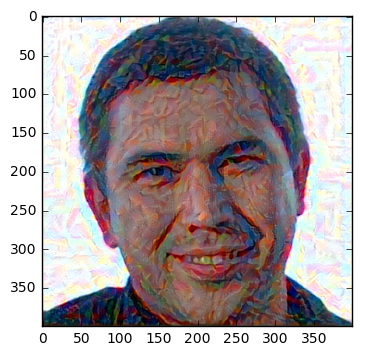

In [59]:
# show image
pylab.imshow(img)